# More advanced fitting formulation

    t0 = 2 * d_spacing
    term0 = a2 * (t - a6)
    term1 = ((a5 - a2) / 2) * (t - a6)
    term3 = erfc(-((t-t0)/(sigma * math.sqrt(2))))
    term4 = np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))
    term5 = erfc(-((t-t0)/(sigma * math.sqrt(2))) + sigma/alpha)
    
    --- iBeatles formulation: this is valid for transmission ----
    y = a1 + term0 + term1 * ( term3 - term4 * term5)
    
    --- For attenuation, or optical density, we have to invert the shape of the step function, and this is what I do here:
    y = a1 + term0 + term1 * (1- (term3 - term4 * term5))

    linear fit of the lines before and after the bragg edge:
    a2=slope of the first line
    a5=slope of the second line
    
    --- a1 and a6 as explained by iBeatles ----
    a6 can be estimated as x-(2*I/(a5-a2), where x= rough position of the edge, I=edge intensity
    a1 can be estimated by intercept of the first or second line from linear fit or intercept+a2*a6 (this is now not so crystal clear)
    
    --- a1 and a6 as derived from me-----
    inter1 = intercept of the first line
    inter2 = intercept of the second line
    a6 = (inter1-inter2)/(a5-a2)
    a1 = inter1 + a2*a6
    
    --matematical derivation of a1 and a6
    y1(t) = a1+a2*(t-a6)  // this happens before the first bragg edge: where the step function is = 0
    y2(t) = a1+a2*(t-a6) + (a5-a2)*(t-a6)
          = a1 + a2*t - a2*a6 +a5*t - a2*t -a5*a6 + a2*a6
          = a1 + a5*t -a5*a6
          
    the two equations become:
    y1(t) = a1 - a2*a6 + a2*t // before the Bragg Edge
    y2(t) = a1 - a5*a6 + a5*t // after the Bragg Edge
    
    then:
    slope1 = a2
    slope2 = a5
    
    inter1 = a1-a2*a6
    inter2 = a1-a5*a6
    
    solving the last two equations:
    inter1-inter2 = a5*a6-a2*a6 -> a6 = (inter1-inter2)/(a5-a2)
    a1 = inter1 + a2*a6



In [1]:
import numpy as np
from numpy import pi, r_, math, random
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.special import erfc
from lmfit import Model
from numpy import loadtxt
%matplotlib inline
# %matplotlib notebook

/home/carminati_c/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def term0(t,a2,a6):
    return  a2 * (t - a6)

In [3]:
def term1(t,a2,a5,a6):
    return ((a5 - a2) / 2) * (t - a6)

In [4]:
def term3(t,t0,sigma):
    return erfc(-((t-t0)/(sigma * math.sqrt(2))))

In [5]:
def term4(t,t0,alpha,sigma):
    return np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))

In [6]:
def term5(t,t0,alpha,sigma):
    return erfc(-((t-t0)/(sigma * math.sqrt(2))) + sigma/alpha)

In [7]:
def AdvancedBraggEdgeFitting(t,t0,alpha,sigma,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))

In [8]:
myspectrum = loadtxt('/home/carminati_c/Documents/vel_selector/alpha.txt') 
# plt.figure
# plt.plot(myspectrum)



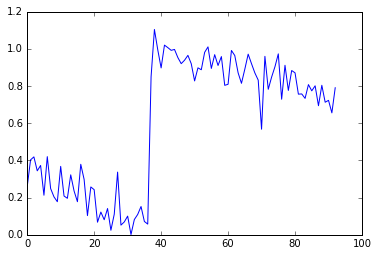

In [9]:
mybragg = -1*np.log(myspectrum[115:208]/np.max(myspectrum[115:208]))
# mybragg = (myspectrum[115:208]/np.max(myspectrum[115:208]))
# mybragg = myspectrum[115:208] # without normalization and without the -log
# mybragg = myspectrum[115:208]
mybragg = mybragg/np.max(mybragg)# iniziamo senza rumore aggiunto
mybragg_clean = mybragg
mybragg = mybragg+ random.normal(0, 0.08, len(mybragg)) # proviamo senza normalizzazione  

plt.figure
plt.plot(mybragg)

## first step: estimate linear function for the slope before and after the Bragg Edge 

In [10]:
t=np.linspace(0,np.size(mybragg)-1,np.size(mybragg))
t_before= t[0:35]
bragg_before=mybragg[0:35]
t_after= t[45:-1]
bragg_after=mybragg[45:-1]

In [11]:
[slope_before, interception_before] = np.polyfit(t_before, bragg_before, 1)
[slope_after, interception_after] = np.polyfit(t_after, bragg_after, 1)

In [12]:
print(slope_before, interception_before)
print(slope_after, interception_after)

(-0.008592877783795555, 0.35466239974864416)
(-0.0047085985229064122, 1.175309525057415)


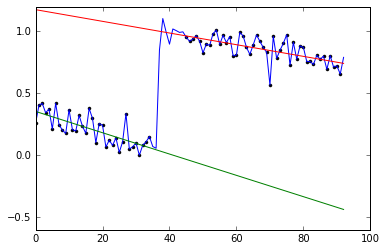

In [13]:
plt.figure
plt.plot(t_before,bragg_before,'.k')
plt.plot(t_after,bragg_after,'.k')
plt.plot(t,mybragg)

plt.plot(t,interception_before+slope_before*t)
plt.plot(t,interception_after+slope_after*t)


In [14]:
def AdvancedBraggEdgeFittingFirstStep(t,a1,a6):
    return a1 + term0(t,a2_f,a6) + term1(t,a2_f,a5_f,a6) * (1-(term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f)))

In [15]:
def AdvancedBraggEdgeFittingSecondStep(t,a2,a5):
    return a1_f + term0(t,a2,a6_f) + term1(t,a2,a5,a6_f) * (1-(term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f)))

In [16]:
def AdvancedBraggEdegFittingThirdStep(t,t0,sigma,alpha):
    return a1_f + term0(t,a2_f,a6_f) + term1(t,a2_f,a5_f,a6_f) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))

In [17]:
def AdvancedBraggEdegFittingFourthStep(t,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f)))

In [18]:
def AdvancedBraggEdegFittingFifthStep(t,t0,sigma,alpha): #this is just the same as the third
    return a1_f + term0(t,a2_f,a6_f) + term1(t,a2_f,a5_f,a6_f) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))

In [19]:
def AdvancedBraggEdegFittingAll(t,t0,sigma,alpha,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))

In [20]:
#first guess of paramters
t0_f=20.0
a2_f=slope_before
a5_f=slope_after
a6_f=t0_f-(2*mybragg[45]/(a5_f-a2_f)) # I assume edge intensity is equal to 1 as I am normalizing
a1_f=interception_before+a2_f*a6_f
sigma_f=-1.0
alpha_f=-1.0
# method='trust_exact'
# method='nelder' #not bad
# method='differential_evolution' # needs bounds
# method='basinhopping' # not bad
# method='lmsquare' # this should implement the Levemberq-Marquardt but it says Nelder-Mead method (which should be Amoeba)
method ='least_squares' # default and it implements the Levenberg-Marquardt

In [21]:
gmodel1 = Model(AdvancedBraggEdgeFittingFirstStep)
gmodel2=Model(AdvancedBraggEdgeFittingSecondStep)
gmodel3=Model(AdvancedBraggEdegFittingThirdStep)
gmodel4=Model(AdvancedBraggEdegFittingFourthStep)
gmodel5=Model(AdvancedBraggEdegFittingFifthStep)
gmodel6=Model(AdvancedBraggEdegFittingAll)

[[Model]]
    Model(AdvancedBraggEdgeFittingFirstStep)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 4
    # data points      = 93
    # variables        = 2
    chi-square         = 13.40839
    reduced chi-square = 0.14734
    Akaike info crit   = -176.11482
    Bayesian info crit = -171.04962
[[Variables]]
    a1:   2.32334944 (init= 4.398547)
    a6:  -187.783779 (init=-470.6089)



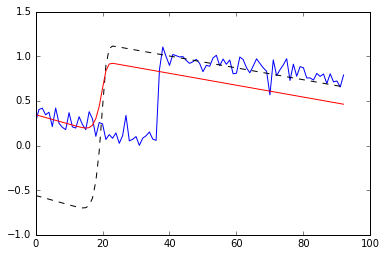

In [22]:
result1 = gmodel1.fit(mybragg, t=t,a1=a1_f, a6=a6_f, method=method) 

# AdvancedBraggEdgeFitting(t,t0,alpha,sigma,a1,a2,a5,a6):


print(result1.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result1.init_fit, 'k--')
plt.plot(t, result1.best_fit, 'r-')
plt.show()

[[Model]]
    Model(AdvancedBraggEdgeFittingSecondStep)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 4
    # data points      = 93
    # variables        = 2
    chi-square         = 13.35282
    reduced chi-square = 0.14673
    Akaike info crit   = -176.50108
    Bayesian info crit = -171.43588
[[Variables]]
    a2:  -0.00854204 (init=-0.008592878)
    a5:  -0.00453312 (init=-0.004708599)



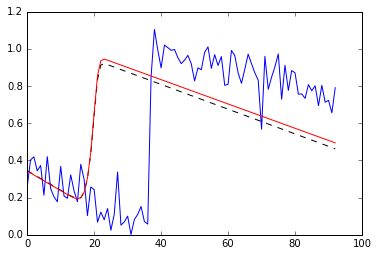

In [23]:
a1_f=result1.best_values.get('a1')
a6_f=result1.best_values.get('a6')

result2=gmodel2.fit(mybragg,t=t, a2=a2_f,a5=a5_f, method=method)
print(result2.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result2.init_fit, 'k--')
plt.plot(t, result2.best_fit, 'r-')
plt.show()


[[Model]]
    Model(AdvancedBraggEdegFittingThirdStep)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 93
    # variables        = 3
    chi-square         = 2.90291
    reduced chi-square = 0.03225
    Akaike info crit   = -316.42034
    Bayesian info crit = -308.82255
[[Variables]]
    t0:      37.0042614 (init= 20)
    sigma:  -0.00027416 (init=-1)
    alpha:  -0.51801968 (init=-1)



/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


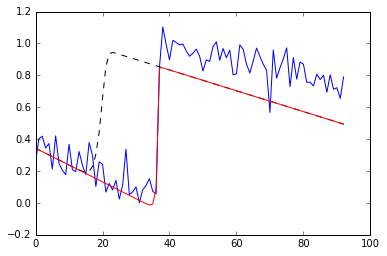

In [24]:
a2_f = result2.best_values.get('a2')
a5_f = result2.best_values.get('a5')

result3 = gmodel3.fit(mybragg,t=t,t0=t0_f,sigma=sigma_f, alpha=alpha_f, nan_policy='propagate', method=method)

print(result3.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result3.init_fit, 'k--')
plt.plot(t, result3.best_fit, 'r-')
plt.show()

[[Model]]
    Model(AdvancedBraggEdegFittingFourthStep)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 93
    # variables        = 4
    chi-square         = 0.56755
    reduced chi-square = 0.00638
    Akaike info crit   = -466.20972
    Bayesian info crit = -456.07933
[[Variables]]
    a1:   1.96636074 (init= 2.323349)
    a2:  -0.00681650 (init=-0.00854204)
    a5:  -0.00226176 (init=-0.004533128)
    a6:  -176.587655 (init=-187.7838)



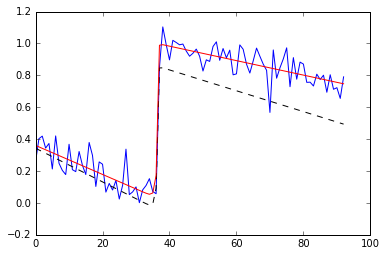

In [25]:
t0_f=result3.best_values.get('t0')
sigma_f=result3.best_values.get('sigma')
alpha_f=result3.best_values.get('alpha')

result4 = gmodel4.fit(mybragg, t=t, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f,nan_policy='propagate', method=method)

print(result4.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result4.init_fit, 'k--')
plt.plot(t, result4.best_fit, 'r-')
plt.show()

[[Model]]
    Model(AdvancedBraggEdegFittingFifthStep)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 93
    # variables        = 3
    chi-square         = 0.53620
    reduced chi-square = 0.00596
    Akaike info crit   = -473.49401
    Bayesian info crit = -465.89621
[[Variables]]
    t0:      37.0481605 (init= 37.00426)
    sigma:  -0.00946603 (init=-0.0002741641)
    alpha:  -0.29163037 (init=-0.5180197)



/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


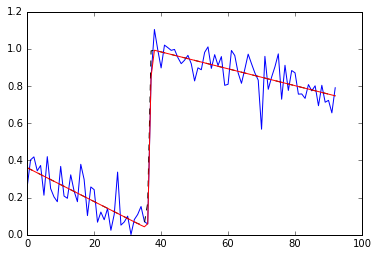

In [26]:
a1_f =result4.best_values.get('a1')
a2_f = result4.best_values.get('a2')
a5_f = result4.best_values.get('a5')
a6_f = result4.best_values.get('a6')

result5=gmodel5.fit(mybragg,t=t, t0=t0_f,sigma=sigma_f, alpha=alpha_f, nan_policy='propagate', method=method)

print(result5.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result5.init_fit, 'k--')
plt.plot(t, result5.best_fit, 'r-')
plt.show()

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 93
    # variables        = 7
    chi-square         = 0.53271
    reduced chi-square = 0.00619
    Akaike info crit   = -466.10028
    Bayesian info crit = -448.37208
[[Variables]]
    t0:      37.0416044 (init= 37.04816)
    sigma:  -0.00314604 (init=-0.009466031)
    alpha:  -0.23187507 (init=-0.2916304)
    a1:      2.29284186 (init= 1.966361)
    a2:     -0.00668407 (init=-0.006816509)
    a5:     -0.00302056 (init=-0.002261763)
    a6:     -227.699622 (init=-176.5877)



/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


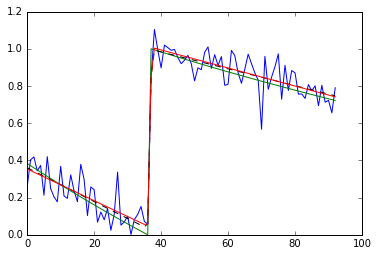

In [27]:
t0_f=result5.best_values.get('t0')
sigma_f=result5.best_values.get('sigma')
alpha_f=result5.best_values.get('alpha')



result6=gmodel6.fit(mybragg,t=t, t0=t0_f,sigma=sigma_f, alpha=alpha_f, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f, nan_policy='propagate', method=method)
# result6=gmodel4.fit(mybragg,t=t, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f, nan_policy='propagate', method='method')

t0_f=result6.best_values.get('t0')
sigma_f=result6.best_values.get('sigma')
alpha_f=result6.best_values.get('alpha')
a1_f =result6.best_values.get('a1')
a2_f =result6.best_values.get('a2')
a5_f =result6.best_values.get('a5')
a6_f =result6.best_values.get('a6')

# result7 = gmodel5.fit(mybragg, t=t,  a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f, nan_policy='propagate', method=method)




print(result6.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, mybragg_clean, 'g')
plt.plot(t, result6.init_fit, 'k--')
plt.plot(t, result6.best_fit, 'r-')
plt.show()

# print(result7.var())
# plt.figure
# plt.plot(t, mybragg, 'b-')
# # plt.plot(t, result7.init_fit, 'k--')
# plt.plot(t, result7, 'r-')
# plt.show()


In [29]:
def ModelFirstPart(t,a1,a2,a6):
    return a1 + term0(t,a2,a6)

In [30]:
def ModelSecondPart(t,a2,a5,a6):
    return 2*term1(t,a2,a5,a6)    

In [31]:
def ModelThirdPart(t, t0, sigma, alpha):
    return (1-0.5*(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))

In [32]:
def ModelA5(t,a5):
    return a1_f + term0(t,a2_f,a6_f) + term1(t,a2_f,a5,a6_f)*(term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f))

(-0.008592877783795555, 0.35466239974864416)
(-0.0047085985229064122, 1.175309525057415)
('a6_f: ', -211.27397650624073)
('a1_f: ', 2.1701138587632642)


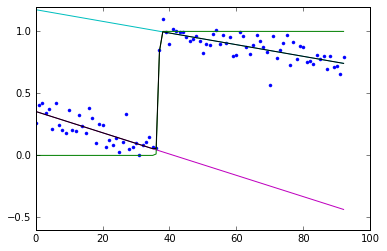

In [33]:
print(slope_before, interception_before)
print(slope_after, interception_after)
a2_f =slope_before
a5_f =slope_after


a6_f = (interception_before-interception_after)/(a5_f-a2_f)
print('a6_f: ', a6_f)

a1_f = interception_before+a2_f*a6_f
print('a1_f: ', a1_f)

result7 = gmodel6.eval(t=t, t0=t0_f,sigma=sigma_f, alpha=alpha_f, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f)

result_firstpart = ModelFirstPart(t=t,a1=a1_f,a2=a2_f,a6=a6_f)
result_secondpart = ModelSecondPart(t=t,a2=a2_f, a5=a5_f, a6=a6_f)
result_thirdpart = ModelThirdPart(t=t, t0=t0_f, sigma=sigma_f, alpha=alpha_f)


plt.figure
plt.plot(t, mybragg, 'b.')
# plt.plot(t, result7, 'r-')
plt.plot(t, result_firstpart,'m')
plt.plot(t, result_firstpart+result_secondpart,'c')
plt.plot(t, result_thirdpart,'g')
plt.plot(t, result_firstpart+result_thirdpart*result_secondpart, 'k')